In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:

data_dir = '../input/brain-tumor-detection'
categories = ['yes', 'no']  
img_size = 224

X = []
y = []


for label, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        try:
            image = load_img(img_path, target_size=(img_size, img_size))
            image = img_to_array(image)
            image = preprocess_input(image)
            X.append(image)
            y.append(label)
        except:
            pass  

X = np.array(X)
y = np.array(y)


In [21]:
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

X_aug = []
y_aug = []

for i in range(len(X)):
    augmented = aug.random_transform(X[i])
    X_aug.append(augmented)
    y_aug.append(y[i])

X_combined = np.concatenate([X, np.array(X_aug)])
y_combined = np.concatenate([y, np.array(y_aug)])


X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)


In [8]:

# Load model without internet
base_model = VGG19(include_top=False, weights=None, input_shape=(224, 224, 3))


# Replace this path with your actual upload path
weights_path = "/kaggle/input/inputvgg19-weights-folder-name/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"


base_model.load_weights(weights_path)

# Create model
model = Model(inputs=base_model.input, outputs=base_model.output)


X_train_features = model.predict(X_train, verbose=1)
X_test_features = model.predict(X_test, verbose=1)

# Flatten features for SVM input
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

print("Extracted feature shape:", X_train_features.shape)

2025-04-17 17:31:46.466785: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1563s 10s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 396s 10s/step
Extracted feature shape: (4800, 25088)


In [9]:

# Train SVM on extracted features
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_features)

# Evaluation
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


 Accuracy: 0.985
 Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       619
           1       0.99      0.98      0.98       581

    accuracy                           0.98      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.99      0.98      0.98      1200

 Confusion Matrix:
 [[611   8]
 [ 10 571]]


In [36]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
import shap
import matplotlib.pyplot as plt

In [37]:
img_size = 224
base_path = '/kaggle/input/brain-tumor-detection'
categories = ['yes', 'no']
max_images_per_class = 50

X = []
y = []

for label in categories:
    folder = os.path.join(base_path, label)
    count = 0
    for img_file in os.listdir(folder):
        if count >= max_images_per_class:
            break
        img_path = os.path.join(folder, img_file)
        try:
            img = load_img(img_path, target_size=(img_size, img_size))
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(label)
            count += 1
        except:
            continue

X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Loaded {len(X)} images.")
print("Classes:", le.classes_)

Loaded 100 images.
Classes: ['no' 'yes']


In [39]:
X_preprocessed = preprocess_input(X)

weights_path = "/kaggle/input/inputvgg19-weights-folder-name/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"


base_model.load_weights(weights_path)
model = Model(inputs=base_model.input, outputs=base_model.output)

features = model.predict(X_preprocessed, verbose=1)
features = features.reshape(features.shape[0], -1)

print("Feature shape before selection:", features.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step
Feature shape before selection: (100, 25088)


In [40]:
selector = SelectKBest(score_func=f_classif, k=300)
X_selected = selector.fit_transform(features, y_encoded)

print("Feature shape after selection:", X_selected.shape)

Feature shape after selection: (100, 300)


Features [    0     1     2 ... 25081 25085 25087] are constant.
divide by zero encountered in divide
invalid value encountered in divide


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

print("SVM Accuracy:", svm_model.score(X_test, y_test))

SVM Accuracy: 0.95


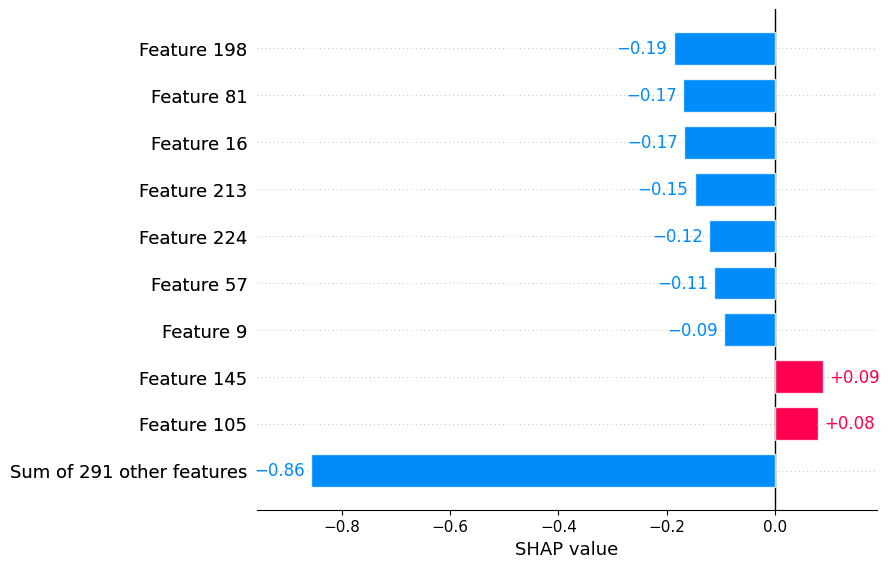

In [43]:
explainer = shap.Explainer(svm_model, X_train)
shap_values = explainer(X_test[:5])

# Plot SHAP Explanation for 1 sample
shap.plots.bar(shap_values[0], max_display=10)

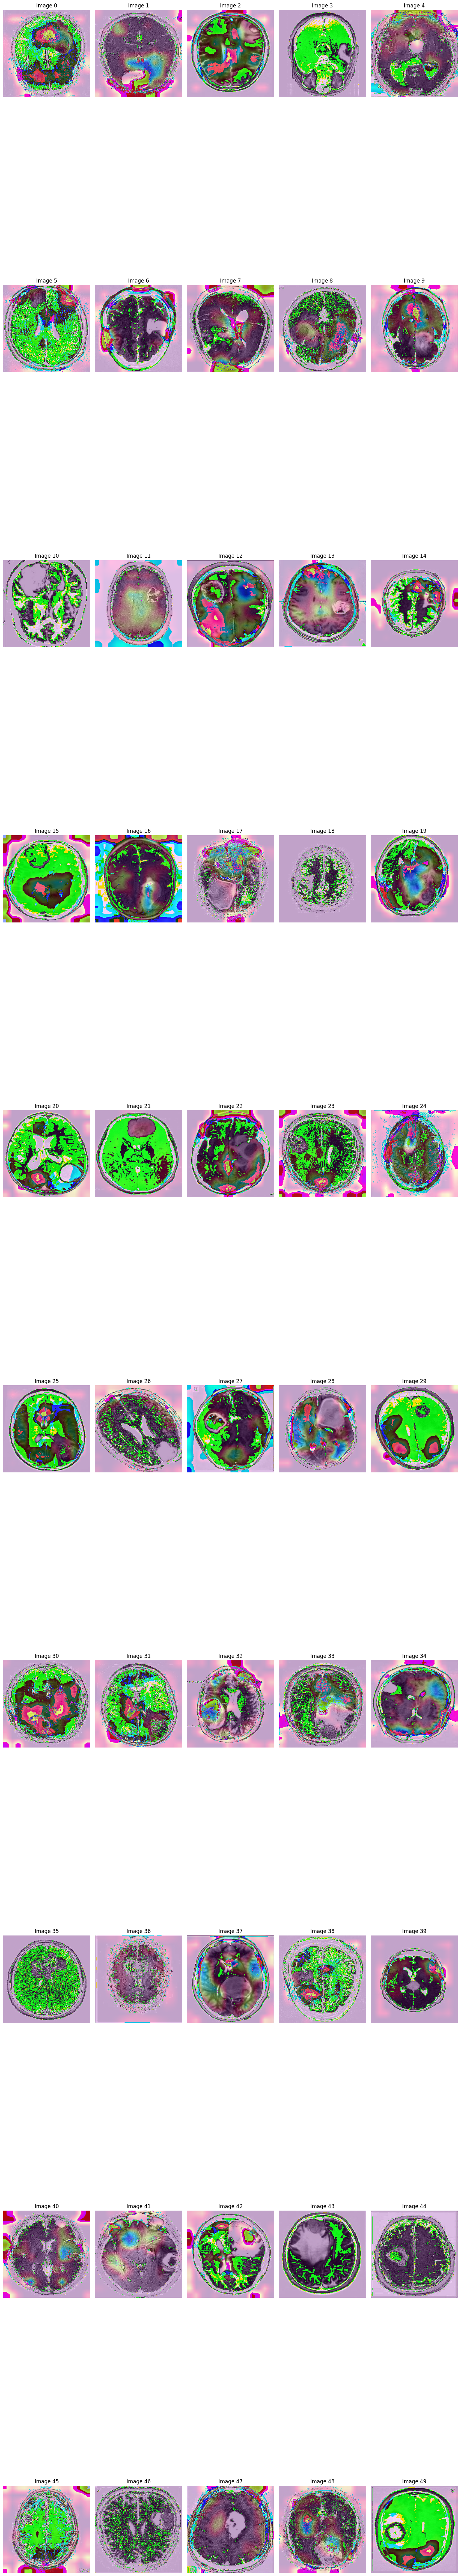

In [61]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input


base_model = VGG19(include_top=False, weights=None, input_shape=(224, 224, 3))


weights_path = "/kaggle/input/inputvgg19-weights-folder-name/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model.load_weights(weights_path)


x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)  
model = tf.keras.Model(inputs=base_model.input, outputs=output)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = int(tf.argmax(predictions[0]))
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()


def show_gradcam_for_multiple_images(X, model, last_conv_layer_name, selected_indices):
    num_images = len(selected_indices)
    plt.figure(figsize=(15, num_images * 2))

    for i, idx in enumerate(selected_indices):
        img = X[idx]

        
        if img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img_resized = cv2.resize(img, (224, 224))
        img_input = preprocess_input(np.expand_dims(img_resized, axis=0))

        heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)

        heatmap_resized = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = heatmap_colored * 0.4 + img_resized

        plt.subplot(num_images // 5 + 1, 5, i + 1)
        plt.imshow(superimposed_img.astype('uint8'))
        plt.axis('off')
        plt.title(f"Image {idx}")

    plt.tight_layout()
    plt.show()


selected_indices = range(50)  
show_gradcam_for_multiple_images(X, model, 'block5_conv4', selected_indices)
